In [ ]:
from chyk import *
handcalcs.set_option("param_columns", 2)
from math import degrees as r2d
from math import radians as d2r
rho = 1.21  # $\frac{kg}{m^3}$, air density
g = 9.81  # $\frac{m}{s^2}$

In [ ]:
from pathlib import Path
import re
import sys
import pandas as pd

#Config stuffs 
IN_DIR  = Path("./rdata")
OUT_DIR = Path("./data")

BRAND_PATTERNS = {
    "ubereats":      re.compile(r"\bubereats\b", re.IGNORECASE),
    "doordash":    re.compile(r"\bdoordash\b", re.IGNORECASE),
    "instacart":      re.compile(r"\binstacart\b", re.IGNORECASE),
    "amazon fresh":      re.compile(r"\bamazon fresh\b", re.IGNORECASE),
    "grubhub":    re.compile(r"\bgrubhub\b", re.IGNORECASE)
}

# _YEAR_RANGE = range(2019, 2026)

def extract_yymm_from_name(name: str) -> str:
    m = re.search(r"(\d{2})[-_](0[1-9]|1[0-2])", name)
    if m:
        yy, mm = m.groups()
        return f"{yy}{mm}"
    raise ValueError(f"O JA WHAT A FAILURE: {name}")

# Things not making sense as numeric should become 0????
def coerce_numeric(series: pd.Series) -> pd.Series:
    return pd.to_numeric(series.astype(str).str.replace(",", ""), errors="coerce").fillna(0)


def summarize_file(csv_path: Path):
    df = pd.read_csv(csv_path, engine="python")

    req = ["BRAND_NAME", "TRANS_COUNT", "SPEND_AMOUNT"]
    df["TRANS_COUNT"] = coerce_numeric(df["TRANS_COUNT"])
    df["SPEND_AMOUNT"] = coerce_numeric(df["SPEND_AMOUNT"])

    yymm = extract_yymm_from_name(csv_path.name)

    out = {}
    for brand_key, pat in BRAND_PATTERNS.items():
        mask = df["BRAND_NAME"].astype(str).str.contains(pat)
        if mask.any():
            sub = df.loc[mask, ["TRANS_COUNT", "SPEND_AMOUNT"]]
            trans_sum = float(sub["TRANS_COUNT"].sum())
            spend_sum = float(sub["SPEND_AMOUNT"].sum())
            out[brand_key] = (yymm, trans_sum, spend_sum)
    return out

# sweepy part
def append_row(rows_dict, brand, yymm, trans, spend):
    rows_dict[brand].append({"YYMM": yymm, "TRANS_COUNT": trans, "SPEND_AMOUNT": spend})

# PROC stuffs
if not IN_DIR.exists():
    print(f"spec a dir pls: {IN_DIR.resolve()}")
    sys.exit(1)
OUT_DIR.mkdir(parents=True, exist_ok=True)

csvs = sorted(IN_DIR.glob("*.csv"))
rows = {k: [] for k in BRAND_PATTERNS.keys()}
for p in csvs:
    try:
        res = summarize_file(p)
    except Exception as e:
        print(f"[WARN] {p.name}: {e}")
        continue
    for brand, (yymm, trans, spend) in res.items():
        append_row(rows, brand, yymm, trans, spend)

# Make the new csvs w data here please work
for brand in rows:
    df_out = pd.DataFrame(rows[brand]).sort_values("YYMM", ascending=True)
    out_path = OUT_DIR / f"{brand}.csv"
    df_out.to_csv(out_path, index=False)
    print(f"[OK] Path @: .\\{out_path}  ({len(df_out)} rows)")

[OK] Path @: .\data\ubereats.csv  (80 rows)
[OK] Path @: .\data\doordash.csv  (80 rows)
[OK] Path @: .\data\instacart.csv  (80 rows)
[OK] Path @: .\data\amazon fresh.csv  (80 rows)
[OK] Path @: .\data\grubhub.csv  (80 rows)


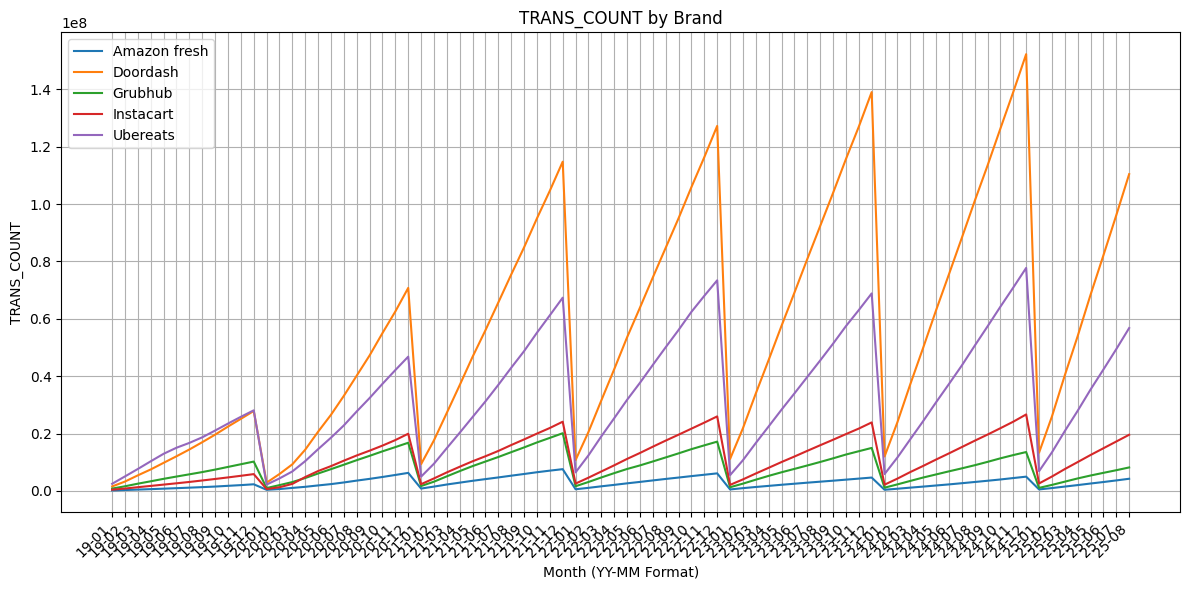

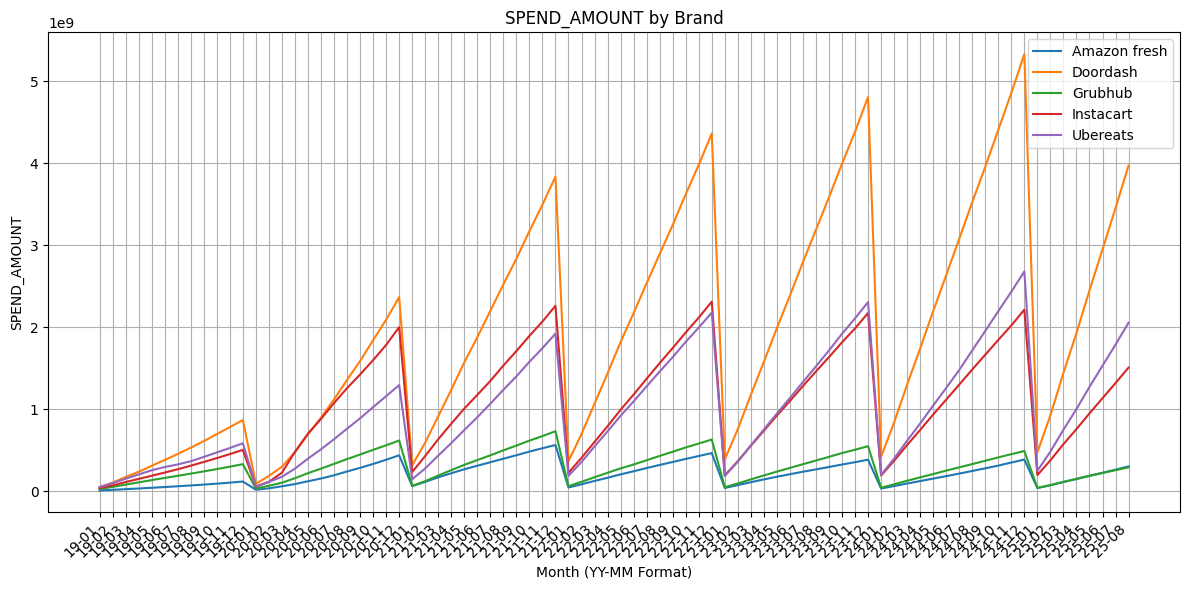

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = Path("./data")

def load_all():
    files = sorted(DATA_DIR.glob("*.csv"))
    series_tc = {}
    series_sp = {}
    for f in files:
        brand = f.stem.strip().lower().capitalize()
        df = pd.read_csv(f)
        dt = pd.to_datetime(df["YYMM"].astype(str), format="%y%m")
        tc = pd.to_numeric(df["TRANS_COUNT"])
        sp = pd.to_numeric(df["SPEND_AMOUNT"])
        series_tc[brand] = pd.Series(tc.values, index=dt).sort_index()
        series_sp[brand] = pd.Series(sp.values, index=dt).sort_index()
    return series_tc, series_sp

def build_union_index(series_dict):
    idx = None
    for s in series_dict.values():
        idx = s.index if idx is None else idx.union(s.index)
    return idx.sort_values()

def make_axis(union_idx, ax, title, ylabel):
    x = np.arange(len(union_idx))
    ax.set_title(title)
    ax.set_xlabel("Month (YY-MM Format)")
    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels([d.strftime("%y-%m") for d in union_idx], rotation=45, ha="right")
    return x

def plot_series(ax, xgrid, union_idx, series_dict):
    for brand, s in series_dict.items():
        y = s.reindex(union_idx).to_numpy()
        mask = ~np.isnan(y)
        ax.plot(xgrid[mask], y[mask], label=brand)
    ax.legend()
    ax.grid(True)

DATA_DIR.mkdir(parents=True, exist_ok=True)
series_tc, series_sp = load_all()

# Plot TRANS_COUNT
union_idx_tc = build_union_index(series_tc)
fig1, ax1 = plt.subplots(figsize=(12, 6))
x_tc = make_axis(union_idx_tc, ax1, "TRANS_COUNT by Brand", "TRANS_COUNT")
plot_series(ax1, x_tc, union_idx_tc, series_tc)
fig1.tight_layout()
fig1.savefig(DATA_DIR / "brand_trans_count.png", dpi=200, bbox_inches="tight")

# Plot SPEND_AMOUNT
union_idx_sp = build_union_index(series_sp)
fig2, ax2 = plt.subplots(figsize=(12, 6))
x_sp = make_axis(union_idx_sp, ax2, "SPEND_AMOUNT by Brand", "SPEND_AMOUNT")
plot_series(ax2, x_sp, union_idx_sp, series_sp)
fig2.tight_layout()
fig2.savefig(DATA_DIR / "brand_spend_amount.png", dpi=200, bbox_inches="tight")

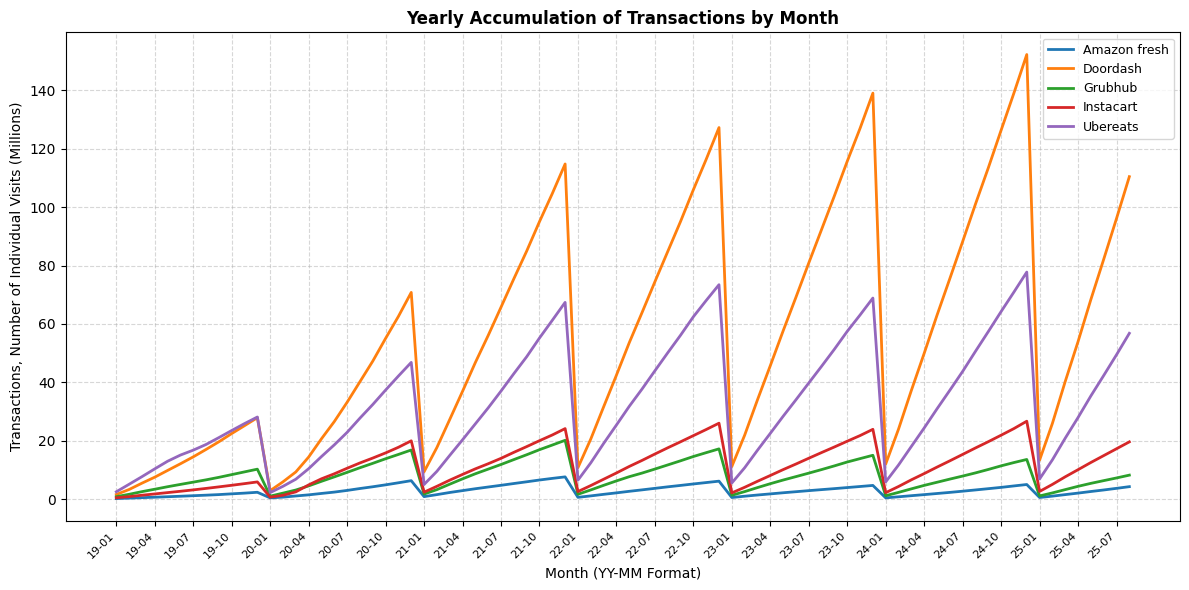

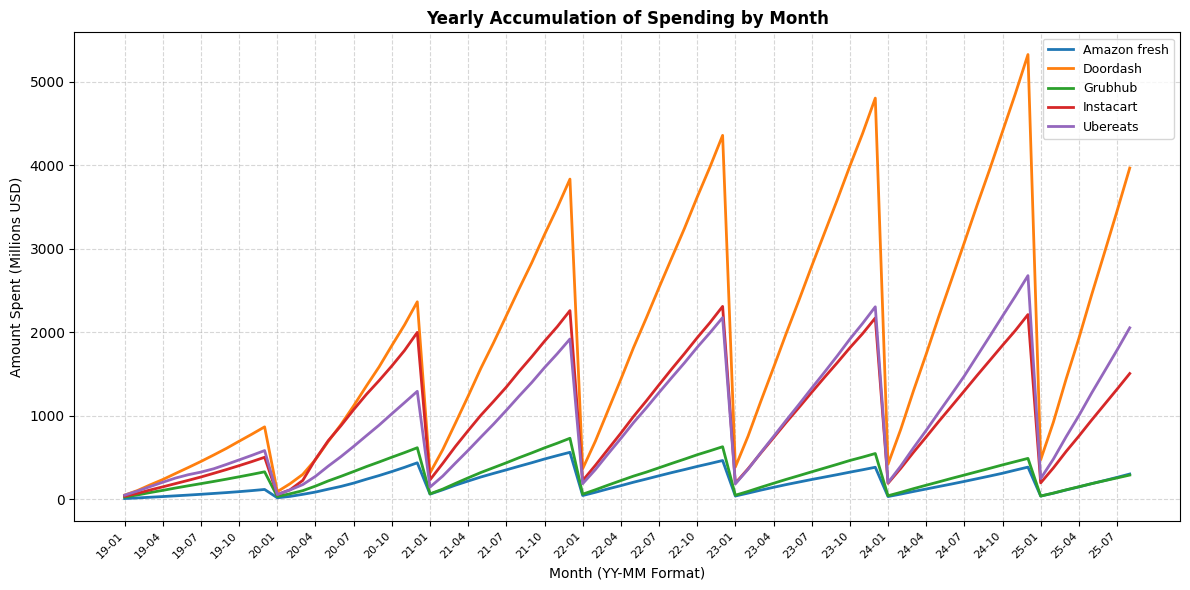

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = Path("./data")

def load_all():
    files = sorted(DATA_DIR.glob("*.csv"))
    series_tc = {}
    series_sp = {}
    for f in files:
        brand = f.stem.strip().lower().capitalize()
        df = pd.read_csv(f)
        dt = pd.to_datetime(df["YYMM"].astype(str), format="%y%m")
        tc = pd.to_numeric(df["TRANS_COUNT"])
        sp = pd.to_numeric(df["SPEND_AMOUNT"])
        series_tc[brand] = pd.Series(tc.values, index=dt).sort_index()
        series_sp[brand] = pd.Series(sp.values, index=dt).sort_index()
    return series_tc, series_sp

def build_union_index(series_dict):
    idx = None
    for s in series_dict.values():
        idx = s.index if idx is None else idx.union(s.index)
    return idx.sort_values()

def make_axis(union_idx, ax, title, ylabel):
    x = np.arange(len(union_idx))
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel("Month (YY-MM Format)")
    ax.set_ylabel(ylabel)
    step = max(1, len(union_idx) // 24)
    tick_positions = x[::step]
    tick_labels = [d.strftime("%y-%m") for d in union_idx[::step]]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha="right", fontsize=8)
    return x

def plot_series(ax, xgrid, union_idx, series_dict):
    # Nike = dark blue, Adidas = black, Lululemon = pink
    color_map = {"Nike": "#0033A0", "Adidas": "black", "Lululemon": "hotpink"}
    for brand, s in series_dict.items():
        y = s.reindex(union_idx).to_numpy() / 1_000_000  # convert to millions
        mask = ~np.isnan(y)
        ax.plot(xgrid[mask], y[mask], label=brand, color=color_map.get(brand, None), linewidth=2)
    ax.legend(fontsize=9)
    ax.grid(True, linestyle="--", alpha=0.5)

DATA_DIR.mkdir(parents=True, exist_ok=True)
series_tc, series_sp = load_all()

# Plot Transactions (Millions of Individual Visits)
union_idx_tc = build_union_index(series_tc)
fig1, ax1 = plt.subplots(figsize=(12, 6))
x_tc = make_axis(union_idx_tc, ax1,
    "Yearly Accumulation of Transactions by Month",
    "Transactions, Number of Individual Visits (Millions)"
)
plot_series(ax1, x_tc, union_idx_tc, series_tc)
fig1.tight_layout()
fig1.savefig(DATA_DIR / "brand_trans_count.png", dpi=200, bbox_inches="tight")

# Plot Spending (Millions USD)
union_idx_sp = build_union_index(series_sp)
fig2, ax2 = plt.subplots(figsize=(12, 6))
x_sp = make_axis(union_idx_sp, ax2,
    "Yearly Accumulation of Spending by Month",
    "Amount Spent (Millions USD)"
)
plot_series(ax2, x_sp, union_idx_sp, series_sp)
fig2.tight_layout()
fig2.savefig(DATA_DIR / "brand_spend_amount.png", dpi=200, bbox_inches="tight")


In [ ]:
base = Path("data")
door_df = pd.read_csv(base / "doordash.csv")
uber_df = pd.read_csv(base / "ubereats.csv")
grub_df = pd.read_csv(base / "grubhub.csv")
insta_df = pd.read_csv(base / "instacart.csv")
amazon_df = pd.read_csv(base / "amazon fresh.csv")

def decumulate(df):
    df = df.copy()
    # yr stuff
    yymm = df["YYMM"].astype(int)
    year = 2000 + (yymm // 100)
    month = yymm % 100
    df["Year"] = year
    df["Month"] = month

    for col in ["TRANS_COUNT", "SPEND_AMOUNT"]:
        df[col] = df.groupby("Year")[col].diff().fillna(df[col])
    # we dont need these??? mayhaps
    df = df.drop(columns=["Year", "Month"])
    return df

door_decum = decumulate(door_df)
uber_decum = decumulate(uber_df)
grub_decum = decumulate(grub_df)
insta_decum = decumulate(insta_df)
amazon_decum = decumulate(amazon_df)

out_path = base / "kikisdelivery.xlsx"
with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
    door_decum.to_excel(writer, sheet_name="doordash", index=False)
    uber_decum.to_excel(writer, sheet_name="ubereats", index=False)
    grub_decum.to_excel(writer, sheet_name="grubhub", index=False)
    insta_decum.to_excel(writer, sheet_name="instacart", index=False)
    amazon_decum.to_excel(writer, sheet_name="amazon fresh", index=False)

out_path


WindowsPath('data/kikisdelivery.xlsx')

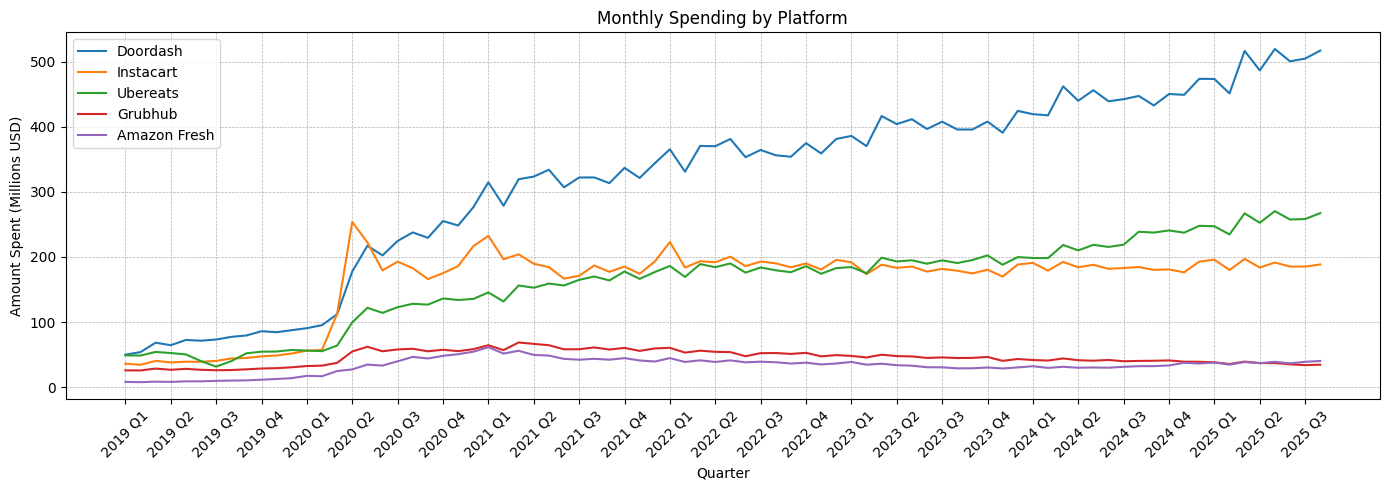

In [ ]:
from functools import reduce
df_door = pd.read_excel("data/kikisdelivery.xlsx", sheet_name="doordash")
df_uber = pd.read_excel("data/kikisdelivery.xlsx", sheet_name="ubereats")
df_grub = pd.read_excel("data/kikisdelivery.xlsx", sheet_name="grubhub")
df_insta = pd.read_excel("data/kikisdelivery.xlsx", sheet_name="instacart")
df_amazon = pd.read_excel("data/kikisdelivery.xlsx", sheet_name="amazon fresh")

# Diff from just uber and dash
dfs = [df_door, df_uber, df_grub, df_insta, df_amazon]
names = ["door", "uber", "grubhub", "instacart", "amazon"]

# rename cols except yymm
for df, n in zip(dfs, names):
    df.rename(columns={c: f"{c}_{n}" for c in df.columns if c != "YYMM"}, inplace=True)
merged = reduce(lambda left, right: pd.merge(left, right, on="YYMM"), dfs)


# mark the dec displays stuff? int cast
yymm = merged["YYMM"].astype(int)
merged["Year"] = (2000 + (yymm // 100)).astype(int)
merged["Month"] = (yymm % 100).astype(int)

# werid int cast succcessss rahh
def quarter_label(row):
    q = (row["Month"] - 1)//3 + 1
    return f"{int(row['Year'])} Q{int(q)}"

merged["Quarter"] = merged.apply(quarter_label, axis=1)
quarter_ticks = merged.drop_duplicates(["Year","Quarter"]).index
quarter_labels = merged.loc[quarter_ticks, "Quarter"].tolist()
x = merged.index





#plotty plot now
# dont need transactions
# fig1, ax1 = plt.subplots(figsize=(14,5))
# ax1.plot(x, merged["TRANS_COUNT_door"]/1e6, label="Doordash")
# ax1.plot(x, merged["TRANS_COUNT_uber"]/1e6, label="Ubereats")
# ax1.set_title("Monthly Transactions by Platform")
# ax1.set_ylabel("Transactions (Millions)")
# ax1.set_xlabel("Quarter")
# ax1.set_xticks(quarter_ticks)
# ax1.set_xticklabels(quarter_labels, rotation=45)
# ax1.grid(True, linestyle="--", linewidth=0.5)
# ax1.legend()
# plt.tight_layout()
# plt.show()

fig2, ax2 = plt.subplots(figsize=(14,5))
ax2.plot(x, merged["SPEND_AMOUNT_door"]/1e6, label="Doordash")
ax2.plot(x, merged["SPEND_AMOUNT_instacart"]/1e6, label="Instacart")
ax2.plot(x, merged["SPEND_AMOUNT_uber"]/1e6, label="Ubereats")
ax2.plot(x, merged["SPEND_AMOUNT_grubhub"]/1e6, label="Grubhub")
ax2.plot(x, merged["SPEND_AMOUNT_amazon"]/1e6, label="Amazon Fresh")
ax2.set_title("Monthly Spending by Platform")
ax2.set_ylabel("Amount Spent (Millions USD)")
ax2.set_xlabel("Quarter")
ax2.set_xticks(quarter_ticks)
ax2.set_xticklabels(quarter_labels, rotation=45)
ax2.grid(True, linestyle="--", linewidth=0.5)
ax2.legend()
plt.tight_layout()
plt.show()


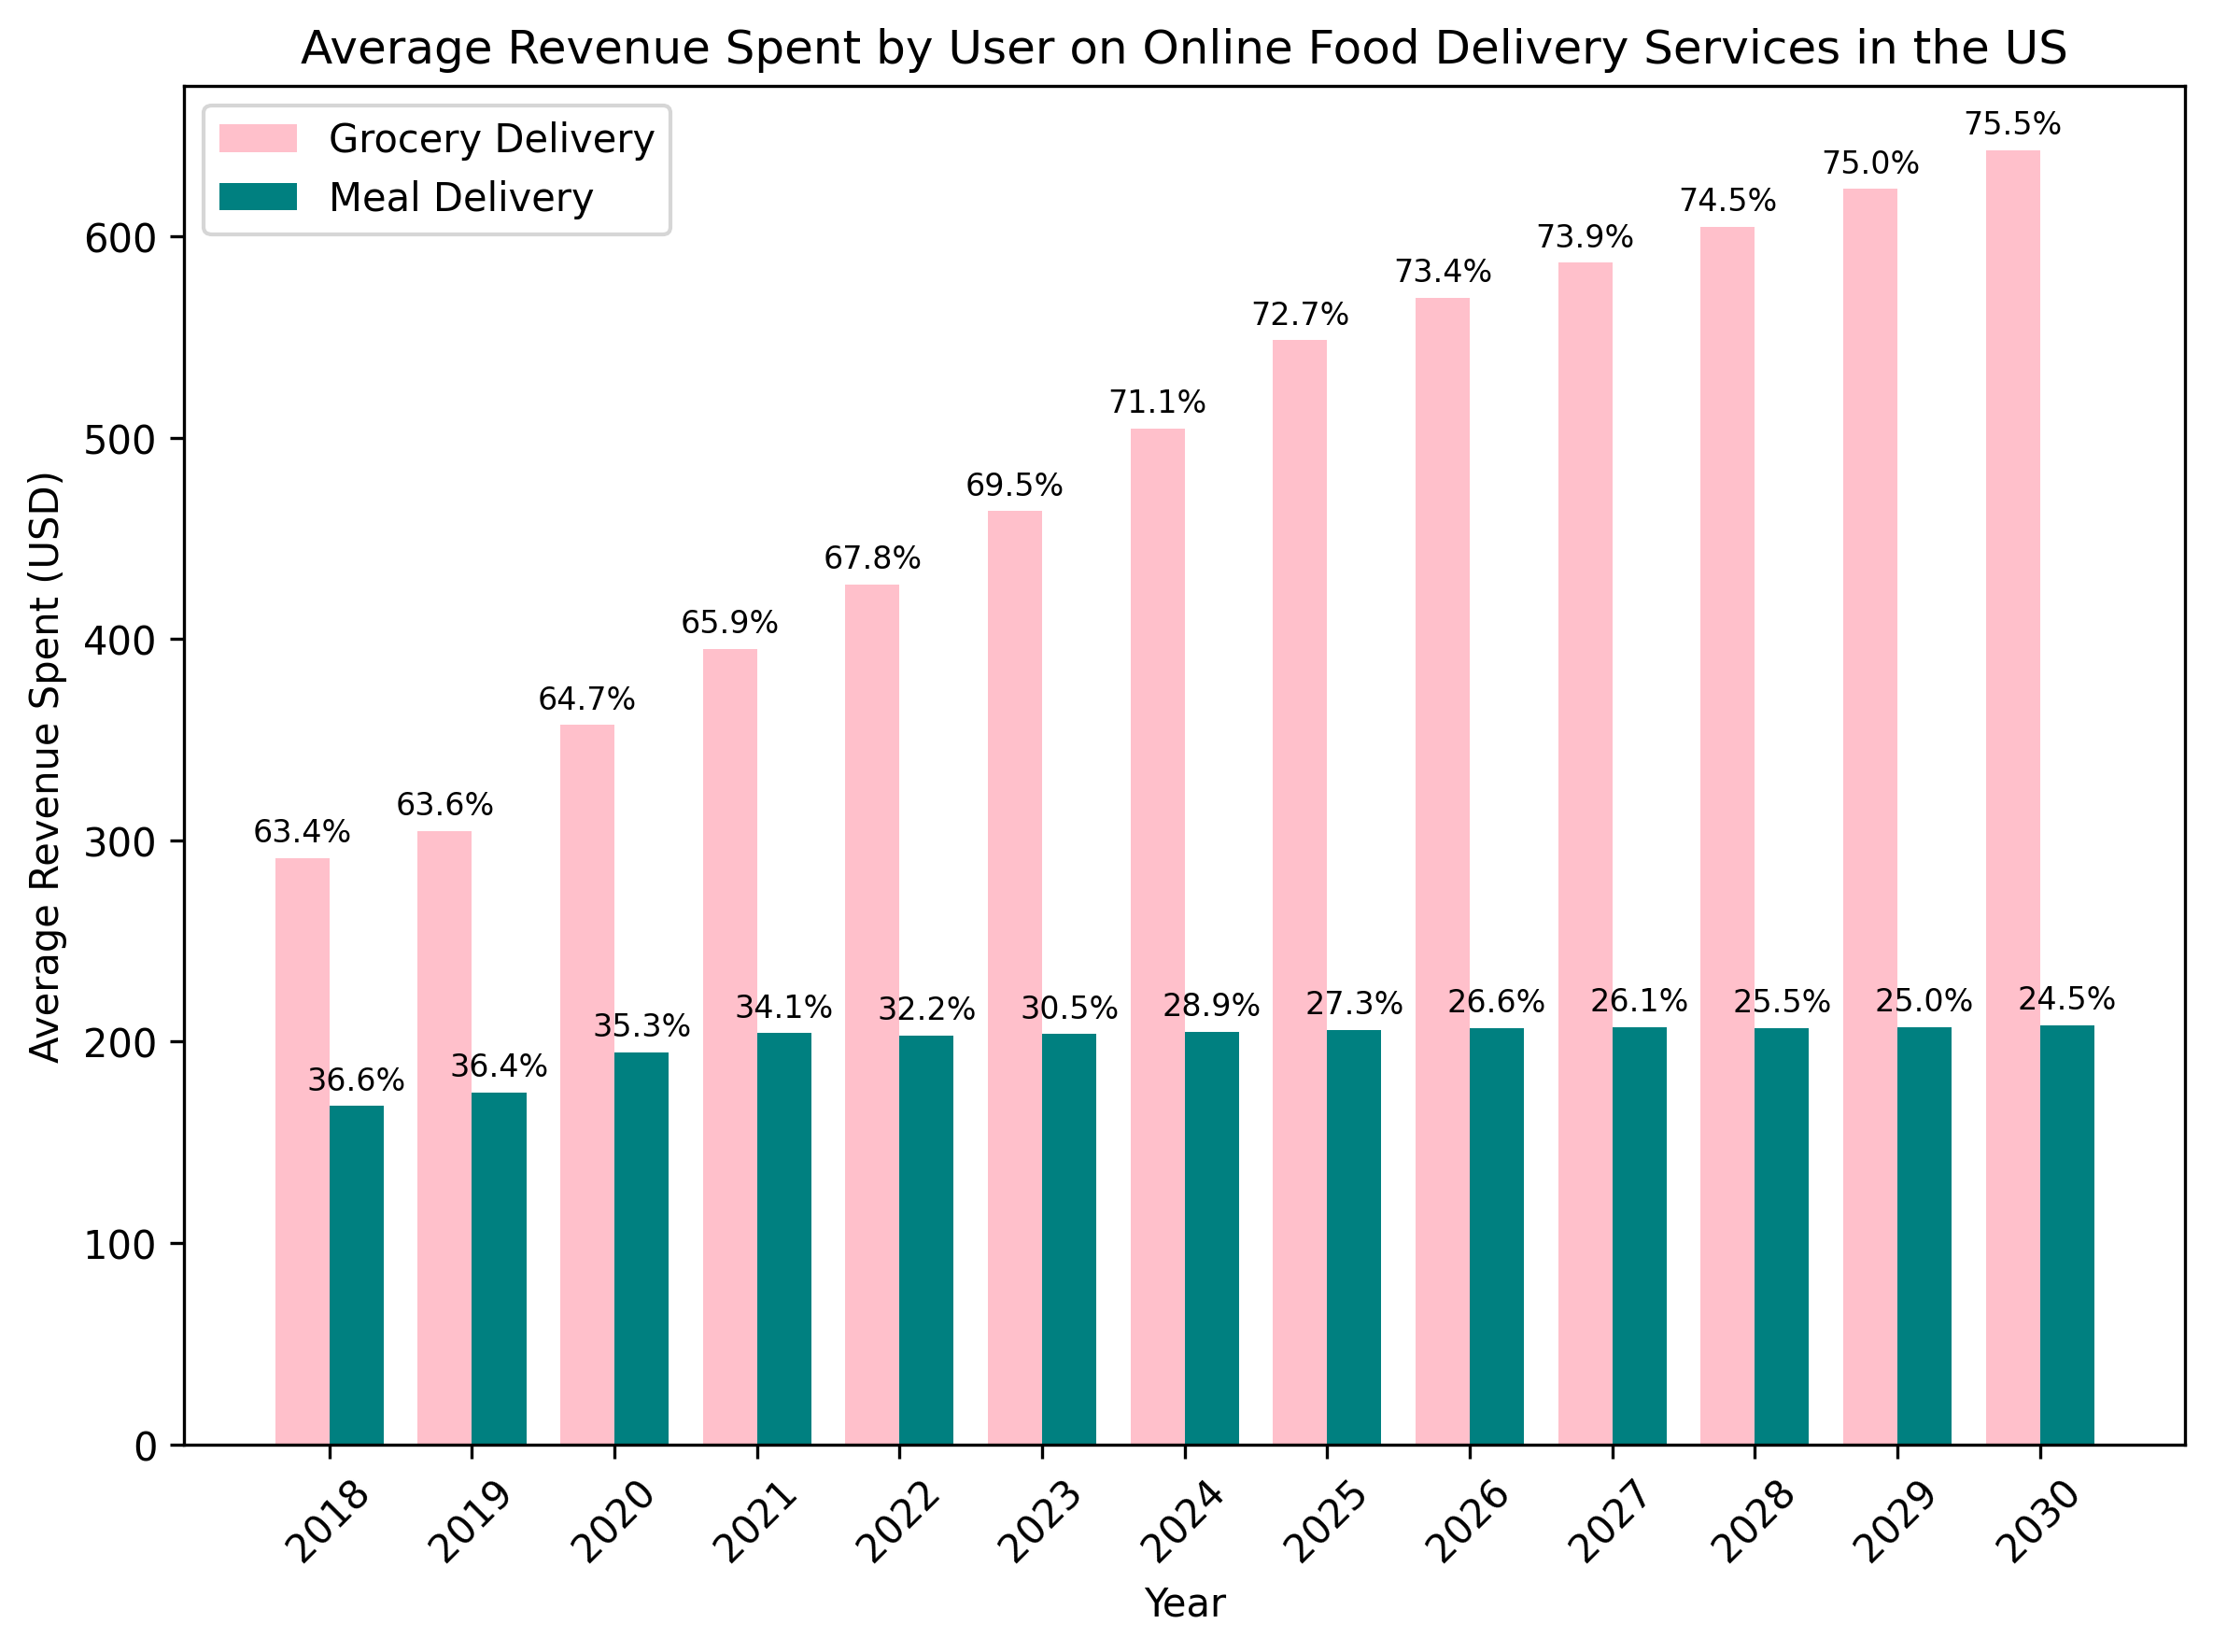

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

path = "data/ecommerce_online-food-delivery_worldwide_USD_en.xlsx"
df = pd.read_excel(path, sheet_name="S0", header=None)

arpu_rows = df.loc[3:, 4].dropna().index
years_arpu = df.loc[arpu_rows, 4].astype(int).to_numpy()
grocery_arpu = df.loc[arpu_rows, 5].astype(float).to_numpy()
meal_arpu = df.loc[arpu_rows, 6].astype(float).to_numpy()
totals = grocery_arpu + meal_arpu
grocery_pct = 100 * grocery_arpu / totals
meal_pct = 100 * meal_arpu / totals

x = np.arange(len(years_arpu))
width = 0.38 
plt.figure(figsize=(8,6), dpi=300)

# pastel time :)
c_meal = "#008080" 
c_grocery = "#FFC0CB"


plt.bar(x - width/2, grocery_arpu, width, color=c_grocery, label="Grocery Delivery")
plt.bar(x + width/2, meal_arpu,    width, color=c_meal,   label="Meal Delivery")

plt.xticks(x, years_arpu, rotation=45)
plt.xlabel("Year")
plt.ylabel("Average Revenue Spent (USD)")
plt.title("Average Revenue Spent by User on Online Food Delivery Services in the US")
plt.legend()

# percent stuff took a fat second but satisfying
for i in range(len(x)):

    plt.text(
        x[i] - width/2, 
        grocery_arpu[i] + 5,
        f"{grocery_pct[i]:.1f}%",
        ha="center",
        va="bottom",
        fontsize=8,
        color="black"
    )

    plt.text(
        x[i] + width/2, 
        meal_arpu[i] + 5,
        f"{meal_pct[i]:.1f}%",
        ha="center",
        va="bottom",
        fontsize=8,
        color="black"
    )

plt.tight_layout()
plt.show()


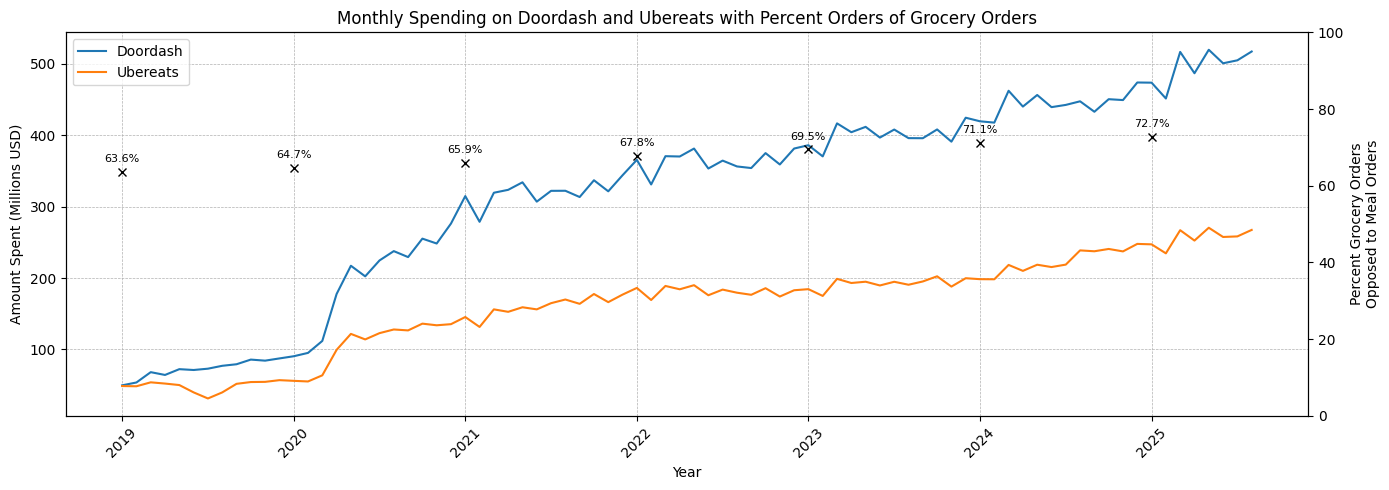

In [ ]:
# grocery % tomfoolery
grocery_map = {int(y): float(p) for y, p in zip(years_arpu, grocery_pct)}

years_in_merged = sorted(merged["Year"].unique()) # one x-pos
year_positions = [merged.index[merged["Year"] == y][0] for y in years_in_merged]

grocery_vals = [grocery_map.get(int(y), np.nan) for y in years_in_merged]

# re-fig
fig3, ax3 = plt.subplots(figsize=(14, 5))
ax3.plot(merged.index, merged["SPEND_AMOUNT_door"] / 1e6, label="Doordash")
ax3.plot(merged.index, merged["SPEND_AMOUNT_uber"] / 1e6, label="Ubereats")
ax3.set_title("Monthly Spending on Doordash and Ubereats with Percent Orders of Grocery Orders")
ax3.set_ylabel("Amount Spent (Millions USD)")
ax3.set_xlabel("Year")

ax3.set_xticks(year_positions)
ax3.set_xticklabels(years_in_merged, rotation=45)
ax3.grid(True, linestyle="--", linewidth=0.5)
ax3.legend(loc="upper left")

axg = ax3.twinx()
axg.set_ylabel("Percent Grocery Orders\nOpposed to Meal Orders")
axg.set_ylim(0, 100)

# markers yay
axg.plot(year_positions, grocery_vals, marker="x", linestyle="none", color="black")

# marklab
for xpos, year, gpct in zip(year_positions, years_in_merged, grocery_vals):
    if np.isnan(gpct):
        continue
    axg.text(xpos, gpct + 2, f"{gpct:.1f}%", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()
